In [1]:
import cirq
from pyLIQTR.scheduler.advanced_decomposition.advanced_decompose import decompose, GateCountingDecompose, SchedulingDecompose, GatesetDecompose
from pyLIQTR.ProblemInstances.getInstance   import *
from pyLIQTR.BlockEncodings.getEncoding     import *
from pyLIQTR.utils.circuit_decomposition    import circuit_decompose_multi
from pyLIQTR.utils.resource_analysis        import estimate_resources
from pyLIQTR.qubitization.qubitized_gates   import QubitizedWalkOperator
from pyLIQTR.clam.lattice_definitions       import CubicLattice, SquareLattice, TriangularLattice
from pyLIQTR.utils.printing                 import openqasm
from pyLIQTR.scheduler.scheduler            import schedule_circuit, decomposition_protocol
import pyLIQTR.scheduler.sets as sets
import qualtran as qt

In [2]:
N=3

J_x = J_y = -0.5;                J_z = -1.0
h_x = 1.0;      h_y = 0.0;       h_z = 0.5

model  =  getInstance( "Heisenberg", 
                       shape=(N,N), 
                       J=(J_x,J_y,J_z), 
                       h=(h_x,h_y,h_z), 
                       cell=SquareLattice )

block_encoding    =  getEncoding(VALID_ENCODINGS.PauliLCU)(model)
circuit = block_encoding.circuit

### Decomposition Types

We have three decomposition types currently implemented:
* `GatesetDecompose`: takes in a set of gate types defined by the user, returns a decomposed circuit only in terms of those gate types.
* `SchedulingDecompose`: returns a circuit at the defined decomposition level with each operator tagged by its individual scheduled time AND the overall circuit scheduling results. See `Examples/Algorithms_and_Infrastructure/scheduling_example.ipynb` for scheduler details.
* `GateCountingDecompose`: returns a circuit at the defined decomposition level with each operator tagged by its individual sub-gate counts (in terms of either a default set of basic gates or a user-defined set of gates) AND the overall circuit gate counts.

Regardless of which decomposition type you wish to use, we recommend accessing the decomposition tool via the `decompose()` function (import details above). The arguments of this function are:
* `circuit`: cirq.Circuit to decompose.
* `analysis_method`: which decomposition type to perform (ex: `GatesetDecompose`).
* `decomposition_level`: levels of decomposition BEFORE analysis. This will dictate at what level the tagged circuit is returned.
* `decomposition_protocol`: whether to use recursive or hierarchical-style decomposition. See figure and explanation below. Input is either `decomposition_protocol.recursive` or `decomposition_protocol.hierarchical`.
* `custom_gateset`: set of gates or operators to serve as the basis for decomposition.
* `return_op_cache`: whether to print cached operators, their cached results, and the number of times they occured. NOTE: this option should not be utilized when using `GatesetDecompose`; it will not result in an error, but will not contain any useful information.

In [3]:
result = decompose(circuit, analysis_method=GatesetDecompose, decomposition_level=0, decomposition_protocol=decomposition_protocol.recursive, custom_gateset=[['An', 'And'], sets.ROT, sets.CLIFFORD, sets.T, sets.MISC])
print(result)

                                                    ┌───────────┐                                     ┌──────────┐                                                                                      ┌──────────┐                                                                                                                                                                                                ┌───────────┐                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [4]:
tagged_circuit, counts = decompose(circuit, analysis_method=SchedulingDecompose, decomposition_level=2, decomposition_protocol=decomposition_protocol.recursive, return_op_cache=True)
print(tagged_circuit)
print(counts)

<pyLIQTR.circuits.operators.prepare_oracle_pauli_lcu.QSP_Prepare object at 0x000001770C646250> occured 1 times and had the following cached results: {'Scheduled Time': 183}.
X occured 2 times and had the following cached results: {'Scheduled Time': 1}.
And occured 62 times and had the following cached results: {'Scheduled Time': 17}.
C+ occured 10 times and had the following cached results: {'Scheduled Time': 0}.
CNOT occured 62 times and had the following cached results: {'Scheduled Time': 2}.
And† occured 62 times and had the following cached results: {'Scheduled Time': 3}.
C+X occured 9 times and had the following cached results: {'Scheduled Time': 9}.
C+Z occured 9 times and had the following cached results: {'Scheduled Time': 7}.
C-XX occured 12 times and had the following cached results: {'Scheduled Time': 5}.
C-YY occured 12 times and had the following cached results: {'Scheduled Time': 19}.
C-ZZ occured 12 times and had the following cached results: {'Scheduled Time': 5}.
<pyLI

In [5]:
from qualtran.cirq_interop.jupyter_tools import svg_circuit
tagged_circuit, counts = decompose(circuit, analysis_method=GateCountingDecompose, decomposition_level=2, decomposition_protocol=decomposition_protocol.recursive, rotations_allowed=True, return_op_cache=True)
svg_circuit(tagged_circuit)
print(tagged_circuit)
print(counts)

<pyLIQTR.circuits.operators.prepare_oracle_pauli_lcu.QSP_Prepare object at 0x000001770CA48250> occured 1 times and had the following cached results: {'T': 0, 'H': 0, 'S': 0, 'CX': 62, 'CZ': 0, 'Pauli (X, Y, Z)': 0, 'Rotation': 63}.
And occured 62 times and had the following cached results: {'T': 4, 'H': 2, 'S': 1, 'CX': 6, 'CZ': 0, 'Pauli (X, Y, Z)': 2, 'Rotation': 0}.
C+ occured 10 times and had the following cached results: {'T': 0, 'H': 0, 'S': 0, 'CX': 0, 'CZ': 0, 'Pauli (X, Y, Z)': 0, 'Rotation': 0}.
And† occured 62 times and had the following cached results: {'T': 0, 'H': 1, 'S': 0, 'CX': 0, 'CZ': 1, 'Pauli (X, Y, Z)': 0, 'Rotation': 0}.
C+X occured 9 times and had the following cached results: {'T': 0, 'H': 0, 'S': 1, 'CX': 2, 'CZ': 0, 'Pauli (X, Y, Z)': 5, 'Rotation': 0}.
C+Z occured 9 times and had the following cached results: {'T': 0, 'H': 0, 'S': 1, 'CX': 2, 'CZ': 0, 'Pauli (X, Y, Z)': 3, 'Rotation': 0}.
C-XX occured 12 times and had the following cached results: {'T': 0, '

In [11]:
estimate_resources(circuit, rotation_gate_precision=1e-10, profile=True)

{'LogicalQubits': 15, 'T': 248, 'Clifford': 1194, 'Rotations': 128}

### Recursive vs. Hierarchical Decomposition

Both pyLIQTR's Advanced Decomposition and Scheduling tools give users an option to choose between recursive and hierarchical decomposition styles. Depending on what size of circuit you are analyzing and what results you want to prioritize, the style you want may vary. The diagram below illustrates how each style works with regards to operation caching:

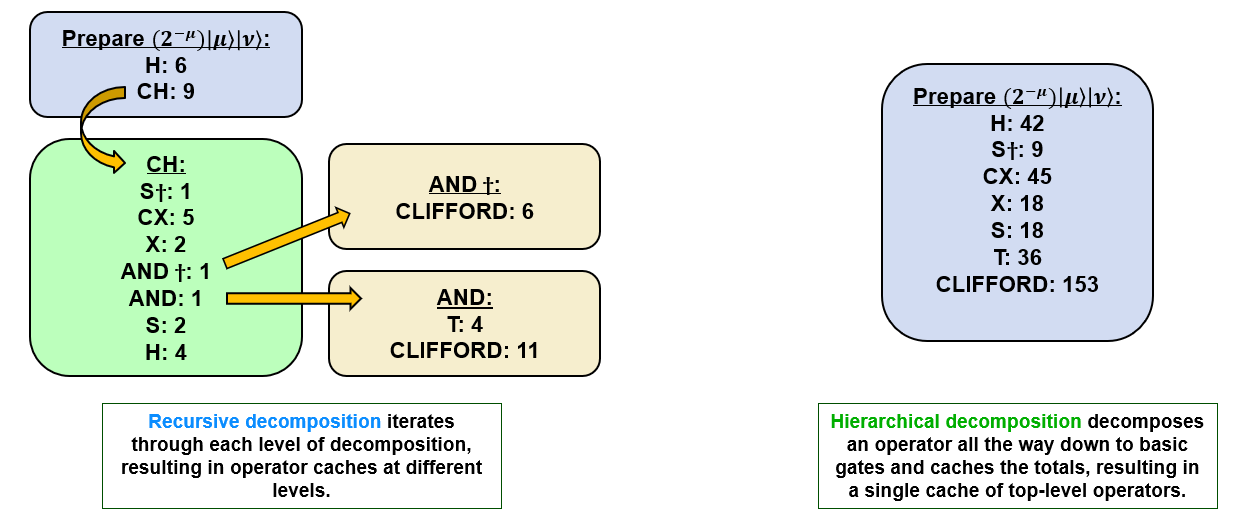

Generally, recursive decomposition is more efficient than and just as accurate as hierarchical decomposition, and is the default protocol for any Advanced Decomposition or Scheduling operation.
